# Setup

In [1]:
#| export
from pyprojroot import here
root = here()
import sys
sys.path.append(str(root))

In [2]:
#| export
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import math

from food_database.train.load_data import MaskedRecipeDataset

# Introduction

Here we want to build the model(s) architecture. 

### Problems 

- Can we not train this model with decision trees? 
    - Transformers make sense as they clearly factor in the input data and the relationships between them. (I also want practice with them).
    - Unsure whether there is enough data to be able to support this model.
    - Ultimately this is a classification problem. Can we not do this with decision trees?
- BERT vs GPT-like?
    - BERT rings a bell since it is bidirectional, and so can attend to any direction of the sequence. However couldn't our problem just be framed as such? We have a set of ingredients, predict which one is likely to come next. Since the GPT-like architecture is already set up for generation it might make the most sense to just use that. It's difficult to know because this is past my limit of knowledge here. Is there ultimately a difference between the two architectures if the problem is framed like so? This is a good question, but it's also worth considering if that even matters. If there is a difference, it will be marginal and not relavent to the project scope.
    - I think I should be working at another level of complexity than this. I am simply just trying to implemenent a base transformer model. BERT and GPT are models on top of this. It's not time to consider this yet.

### Notes 

- Guide calls feed forward networks PositionWiseFeedForward - is there anything special that makes them positional, or is this name for guidance?

### Approach

What should the approach be here. It's a good idea to start simple all the way to the end, and build my way up incrementally. However how simple do we want / can we go? 

It makes sense to use a transformer, as the attention mechanism is what will be driving the predictions here. If we started with something even more simple, ie. a linear layer, we would need a way of feeding in the input data, in order to form predictions for the output ie. the masked tokens. This method of feeding in the input data would be something very crude, like adding the token vectors together. It just wouldn't work.

Let's use a transformer. It could be simple if thought of as a black-box, where all my focus would be just getting it to run. The other option is to write my own version of a transformer (with references), with an attempt to make it as simple as possible. ie. single layer feed-forward networks, single head of attention, no other masking, no misc techiniques such as dropout etc.

# Train Test

Here we want to get a model to run on our data. We will just use a black-box pytorch Transformer (which output the same dimension vector as the inputs?).

There are a number of reasons we aren't expecting quality predictions:

- Data
    - Small dataset sample
    - Not scaled
- Model
    - Parameter initialisation (might be built in)
    - Incorrect loss function (should evalute only masks - transformer is not predicing it is transforming here)
    - Architecture optimisations - probably unnecessary.

https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch
https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 2
n_epochs = 5000
learning_rate = 1e-3

In [4]:
food_vectors = torch.tensor(np.load('../../data/local/final/food_compounds/0.npy'), dtype=torch.float).to(device)
food_vectors, food_vectors.shape

(tensor([[0.0000, 0.0000, 0.1093,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1093,  ..., 0.0000, 0.0000, 1.2232],
         [0.0000, 0.0000, 0.1093,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
        device='cuda:0'),
 torch.Size([1108, 713]))

In [5]:
data_ratios = [0.8, 0.2]

data = np.load('../../data/local/final/recipe_food_ids/0.npy')

np.random.shuffle(data)

data_train = data[:int(data_ratios[0]*len(data))]
data_validation = data[int(data_ratios[0]*len(data)):]

data.shape, data_train.shape, data_validation.shape

((302, 15), (241, 15), (61, 15))

In [6]:
train_dl = DataLoader(MaskedRecipeDataset(data), batch_size=batch_size, shuffle=True)
validation_dl = DataLoader(MaskedRecipeDataset(data), batch_size=batch_size, shuffle=False)

xb, yb = next(iter(train_dl))
xb.shape

torch.Size([2, 15])

In [19]:
model = nn.Transformer(
    d_model=food_vectors.shape[1], 
    nhead=1,
    num_encoder_layers=1,
    num_decoder_layers=1,
    dim_feedforward=800,
    dropout=0,
    batch_first=True
)

model.to(device)

loss_func = nn.CrossEntropyLoss() #TODO: make custom to only measure masked loss

optimizer = AdamW(model.parameters(), lr=learning_rate)

In [20]:
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

8.403592 M parameters


In [42]:
training_metrics = []

for epoch in range(n_epochs):

    # get sample of data
    xb, yb = next(iter(train_dl))
    xb = torch.stack([food_vectors[b] for b in xb]).to(device)
    yb = torch.stack([food_vectors[b] for b in yb]).to(device)

    # evaluate loss 
    output = model(xb,yb)
    train_loss = loss_func(output, yb)
    optimizer.zero_grad(set_to_none=True)
    train_loss.backward()
    optimizer.step()

    if epoch % 10 == 0:

        xb_validation, yb_validation = next(iter(validation_dl))
        xb_validation = torch.stack([food_vectors[b] for b in xb_validation])
        yb_validation = torch.stack([food_vectors[b] for b in yb_validation])

        with torch.no_grad():
            output = model(xb_validation, yb_validation)
            validation_loss = loss_func(output, yb_validation)

        training_metrics.append({
            'epoch': epoch, 'train_loss': train_loss.to('cpu'), 'validation_loss': validation_loss.to('cpu'), 'validation_output': output, 'validation_target': yb_validation
        })

In [31]:
training_metrics[100]['validation_output'][0]

tensor([[ 0.3616, -0.0326,  1.7352,  ..., -0.2227,  0.2965,  1.3963],
        [ 0.6556,  0.1868, -0.5410,  ..., -0.0951,  0.1144, -0.0409],
        [ 0.2447, -0.1630,  2.5954,  ..., -0.2422,  0.3562,  2.0182],
        ...,
        [ 0.1364,  0.1424, -1.5657,  ...,  0.1731, -0.2873, -0.8852],
        [ 0.1364,  0.1424, -1.5657,  ...,  0.1731, -0.2873, -0.8852],
        [ 0.1364,  0.1424, -1.5657,  ...,  0.1731, -0.2873, -0.8852]],
       device='cuda:0')

In [41]:
from scipy import spatial

tree = spatial.KDTree(food_vectors.to('cpu'))

output = training_metrics[100]['validation_output'][0].to('cpu')

for food in output:
    print(tree.query(food))

(52.035335420633324, 1107)
(53.093309950026395, 637)
(46.967519409145034, 1107)
(52.05657858237572, 1107)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)


In [43]:
output = training_metrics[100]['validation_target'][0].to('cpu')

for food in output:
    print(tree.query(food))

(0.0, 269)
(0.0, 631)
(0.0, 460)
(0.0, 13)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)


That's not good. We are transforming the tokens mostly to masked tokens.

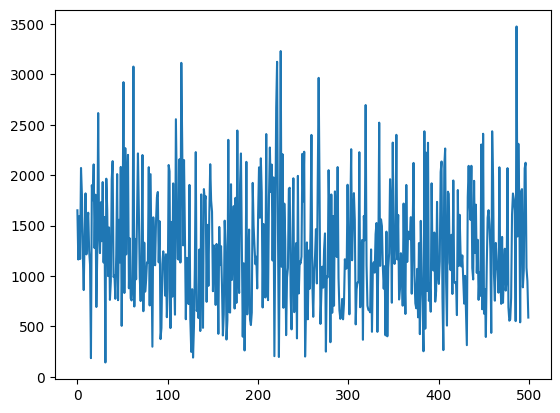

In [44]:
import matplotlib.pyplot as plt

plt.plot([m['train_loss'].detach().numpy() for m in training_metrics])